**Dataset**

- Paper: Edge-IIoTset: A New Comprehensive Realistic Cyber Security Dataset of IoT and IIoT Applications for Centralized and Federated Learning
- Published in: IEEE Access
- Date: 08 April 2022
- Links: 
    - https://ieeexplore.ieee.org/document/9751703
    - https://www.kaggle.com/code/salma20/edge-iiotset-binary-classification

## Load Dataset

In [1]:
import json

with open('edge-iiotset-train.json') as f:
    train_set = json.load(f)

with open('edge-iiotset-test.json') as f:
    test_set = json.load(f)

# Evaluate LLM Models

## OpenAI

In [23]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import tiktoken
import os
import dotenv
from sklearn.metrics import classification_report

dotenv.load_dotenv()
API_KEY = os.getenv("MY_OPENAI_API_KEY")
llm = ChatOpenAI(openai_api_key=API_KEY, temperature=0.0)
encoding = tiktoken.encoding_for_model("gpt-4o-mini-2024-07-18")

train_set_size = 25
test_set_size = 25

y_true = {}
y_pred = {}

def predict(attack_type):
    messages = []
    system_prompt = ("system", f"You are intelligent log analyzer. User gives you samples of benign and attack iot network data. When user ask to predict the label given a sample, analyze the samples and check whether the sample is benign or not. Output the label ATTACK or BENIGN, nothing else. The samples has following fields respectively {random_samples_ddos_dfs[attack_type].columns.tolist()}.")

    benign_samples = ""
    attack_samples = ""
    for i in range(train_set_size):
        benign_samples += str(random_samples_normal_dfs[attack_type].iloc[i].values.tolist()) + ">>> BENIGN\n"
        attack_samples += str(random_samples_ddos_dfs[attack_type].iloc[i].values.tolist()) + ">>> ATTACK\n"
    user_prompt = ("user", "Sample logs are given below ```" + benign_samples + attack_samples + "```")
    messages.append(system_prompt)
    messages.append(user_prompt)
    messages.append(("user", "{input}"))

    # print("Messages:", messages)
    num_tokens = len(encoding.encode(str(messages)))
    print("Num tokens:", num_tokens)

    prompt = ChatPromptTemplate.from_messages(messages)
    chain = prompt | llm 

    y_true[attack_type] = []
    y_pred[attack_type] = []

    print("Predicting benign samples...")
    for i in range(train_set_size, train_set_size + test_set_size):
        
        y_true[attack_type].append("BENIGN")
        y_pred[attack_type].append(chain.invoke({"input": "Predict attack or benign: " + 
                                    str(random_samples_normal_dfs[attack_type].iloc[i].values.tolist())}).content)

    print("Predicting attack samples...")
    for j in range(train_set_size, train_set_size + test_set_size):
        y_true[attack_type].append("ATTACK")
        y_pred[attack_type].append(chain.invoke({"input": "Predict attack or benign: " + 
                                    str(random_samples_ddos_dfs[attack_type].iloc[j].values.tolist())}).content)

    print(classification_report(y_true[attack_type], y_pred[attack_type]))



In [24]:
for attack_type in attack_types[:1]:
    print(f"Predicting for attack type: {attack_type}")
    predict(attack_type)


Predicting for attack type: DDoS_HTTP
Num tokens: 13085
Predicting benign samples...
Predicting attack samples...
              precision    recall  f1-score   support

      ATTACK       0.62      1.00      0.77        25
      BENIGN       1.00      0.40      0.57        25

    accuracy                           0.70        50
   macro avg       0.81      0.70      0.67        50
weighted avg       0.81      0.70      0.67        50



In [14]:
llm.model_name

'gpt-3.5-turbo'

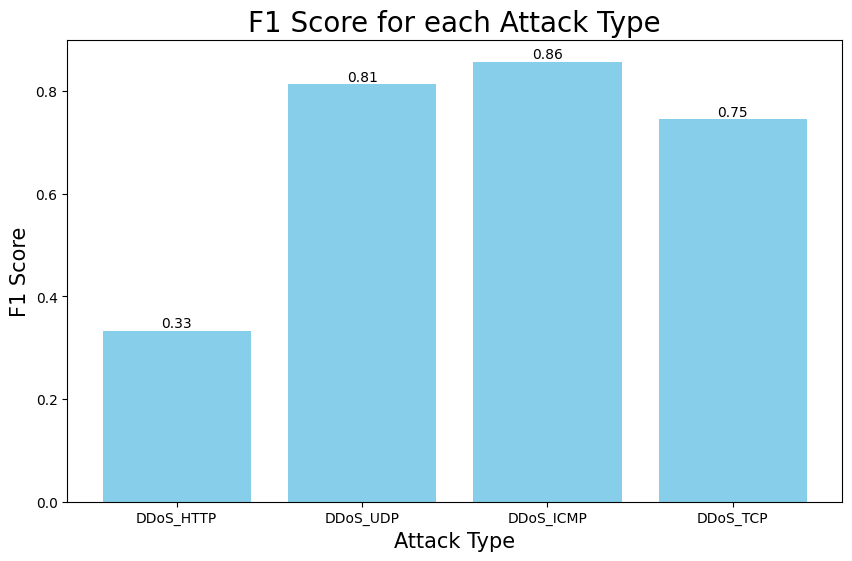

In [14]:
# get f1_score for each attack type
f1_scores = {}
for attack_type in attack_types:
    f1_scores[attack_type] = classification_report(y_true[attack_type], y_pred[attack_type], output_dict=True)['weighted avg']['f1-score']

# plot f1_score for each attack type
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.title('F1 Score for each Attack Type', fontsize=20)
plt.xlabel('Attack Type', fontsize=15)
plt.ylabel('F1 Score', fontsize=15)
for i in range(len(f1_scores)):
    plt.text(i, f1_scores[list(f1_scores.keys())[i]], round(f1_scores[list(f1_scores.keys())[i]], 2), ha = 'center', va = 'bottom')
plt.show()

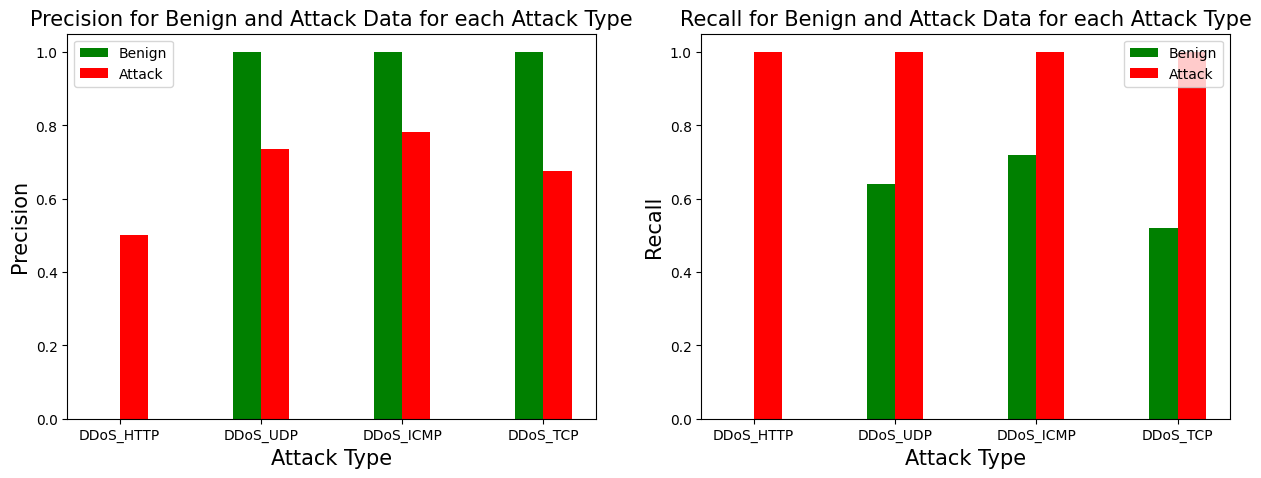

In [15]:
# get precision for benign data for each attack type
precision_benign = {}
precision_attack = {}
recall_benign = {}
recall_attack = {}
for attack_type in attack_types:
    precision_benign[attack_type] = classification_report(y_true[attack_type], y_pred[attack_type], output_dict=True)['BENIGN']['precision']
    precision_attack[attack_type] = classification_report(y_true[attack_type], y_pred[attack_type], output_dict=True)['ATTACK']['precision']
    recall_benign[attack_type] = classification_report(y_true[attack_type], y_pred[attack_type], output_dict=True)['BENIGN']['recall']
    recall_attack[attack_type] = classification_report(y_true[attack_type], y_pred[attack_type], output_dict=True)['ATTACK']['recall']


# Create 2 subplots for precision and recall for benign and attack data for each attack type
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# in subplot 1, plot precision for benign and attack data for each attack type
# bening columns should be green and attack columns should be red
# bars should be side by side for each attack type
# x-axis should be attack types with strings
bar_width = 0.2
x = np.arange(len(attack_types))
axs[0].bar(x - bar_width/2, precision_benign.values(), bar_width, color='green', label='Benign')
axs[0].bar(x + bar_width/2, precision_attack.values(), bar_width, color='red', label='Attack')
axs[0].set_title('Precision for Benign and Attack Data for each Attack Type', fontsize=15)
axs[0].set_xlabel('Attack Type', fontsize=15)
axs[0].set_ylabel('Precision', fontsize=15)
axs[0].set_xticks(x)
axs[0].set_xticklabels(attack_types)
axs[0].legend()

# in subplot 2, plot recall for benign and attack data for each attack type
# bening columns should be green and attack columns should be red
# bars should be side by side for each attack type
axs[1].bar(x - bar_width/2, recall_benign.values(), bar_width, color='green', label='Benign')
axs[1].bar(x + bar_width/2, recall_attack.values(), bar_width, color='red', label='Attack')
axs[1].set_title('Recall for Benign and Attack Data for each Attack Type', fontsize=15)
axs[1].set_xlabel('Attack Type', fontsize=15)
axs[1].set_ylabel('Recall', fontsize=15)
axs[1].set_xticks(x)
axs[1].set_xticklabels(attack_types)
axs[1].legend()

plt.show()

## Ollama

In [ ]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
import tiktoken

train_set_size = 25
test_set_size = 25

y_true = {}
y_pred = {}

def predict(attack_type, model):
    llm = ChatOllama(model=model, temperature=0)
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    messages = []
    system_prompt = ("system", f"You are intelligent log analyzer. User gives you samples of benign and attack iot network data. Analyze the samples and check whether the user given data is benign or not. Output the label ATTACK or BENIGN, nothing else. The samples has following fields respectively {random_samples_ddos_dfs[attack_type].columns.tolist()}.")

    benign_samples = ""
    attack_samples = ""
    for i in range(train_set_size):
        benign_samples += str(random_samples_normal_dfs[attack_type].iloc[i].values.tolist()) + ">>> BENIGN\n"
        attack_samples += str(random_samples_ddos_dfs[attack_type].iloc[i].values.tolist()) + ">>> ATTACK\n"
    user_prompt = ("user", "Sample logs are given below ```" + benign_samples + attack_samples + "```")
    messages.append(system_prompt)
    messages.append(user_prompt)
    messages.append(("user", "{input}"))

    # print("Messages:", messages)
    num_tokens = len(encoding.encode(str(messages)))
    print("Num tokens:", num_tokens)

    prompt = ChatPromptTemplate.from_messages(messages)
    chain = prompt | llm | StrOutputParser()

    y_true[attack_type] = []
    y_pred[attack_type] = []

    print("Predicting benign samples...")
    for i in range(train_set_size, train_set_size + test_set_size):
        
        y_true[attack_type].append("BENIGN")
        y_pred[attack_type].append(chain.invoke({"input": "Predict attack or benign: " + 
                                    str(random_samples_normal_dfs[attack_type].iloc[i].values.tolist())}))
        print(i-train_set_size+1, end=" ")

    print("\nPredicting attack samples...")
    for j in range(train_set_size, train_set_size + test_set_size):
        y_true[attack_type].append("ATTACK")
        y_pred[attack_type].append(chain.invoke({"input": "Predict attack or benign: " + 
                                    str(random_samples_ddos_dfs[attack_type].iloc[j].values.tolist())}))
        print(j-train_set_size+1, end=" ")

    print(classification_report(y_true[attack_type], y_pred[attack_type]))